In [1]:
### A1. Membaca data mentah ###
### ----------------------- ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import radviz

In [2]:
# Source directory and result #
src = r'SampleDataCsv.csv'
df = pd.read_csv(src, sep='|')

str1 = 'AsofDate'
str2 = 'CIF'
str3 = 'Collectibility'
str4 = 'Plafond'
str5 = 'Oustanding'
str6 = 'Business_Type'
str7 = 'OpenDate'
str8 = 'LOB'
str9 = 'DelQ'
str10 = 'Collateral_Type'
str11 = 'Collateral_Value'

df2 = df.groupby([str1, str2]).agg({ str3:'max'
                              ,str4:'max'
                              ,str5:'max'
                              ,str6:'max'
                              ,str7:'max'
                              ,str8:'max'
                              ,str9:'max'
                              ,str10:'max'
                              ,str11:'max'})[[str3
                                             ,str4
                                             ,str5
                                             ,str6
                                             ,str7
                                             ,str8
                                             ,str9
                                             ,str10
                                             ,str11]].reset_index()

In [3]:
# print(df2)

## Additional coloumn ##
df2["Sisa_Plafond"] = df2[str4] - df2[str5]

In [4]:
## Bucket Dpd - range mapping value ## 
bins = [0, 1, 30, 60, 90, 120, 150, 180]
names = ['1_Current', '2_DPD1+', '3_DPD30+', '4_DPD60+', 
         '5_DPD90+', '6_DPD120+', '7_DPD150+', '8_DPD180+']
d = dict(enumerate(names, 1))
df2['Bucket'] = np.vectorize(d.get)(np.digitize(df2[str9], bins))

In [5]:
## Kolektibitas mapping ## 
bins = [1, 2, 5]
names = ['1_Current', '2_SM', '3_NPL']
d = dict(enumerate(names, 1))
df2['Collectibility_Desc'] = np.vectorize(d.get)(np.digitize(df2[str3], bins))

In [6]:
## Oustanding ##
bins = [0, 50000000, 80000000, 100000000, 250000000, 350000000]
names = ['A_0-50 Jt', 'B_>50-80 Jt', 'C_>80-100 Jt', 
         'D_>100-250 Jt', 'E_>250-350 Jt', 'F_>350 Jt']
d = dict(enumerate(names, 1))
df2['Oustanding_Band'] = np.vectorize(d.get)(np.digitize(df2[str5], bins))

In [7]:
## Temporary ##
Collectibility = df2['Collectibility'].astype(int)
Collateral_Value = df2['Collateral_Value'].astype(float)
OS = df2["Oustanding"].astype(int)

In [8]:
# df2['Collateral_remains'] = OS - Collateral_Value
df2.loc[(Collateral_Value < OS), 'Collateral_remains'] = OS - Collateral_Value
df2.loc[(Collateral_Value > OS), 'Collateral_remains'] = 0
df2.loc[(Collateral_Value == OS), 'Collateral_remains'] = 0
df2.dropna(inplace=True)

In [9]:
## Grouping tipe bisnis ##
Business_Type = df2['Business_Type'].astype(int)
df2.loc[(Business_Type.isin([9990,1019,6000,1007])), 'Type_Buss'] = Business_Type
df2.loc[(Business_Type.isin([1001,1004,1008,1015,1020,8000,9000,1014,1016])), 'Type_Buss'] = 'Other'
df2.loc[(Business_Type > 150000), 'Type_Buss'] = 'Other'

In [10]:
## Create Debtor current month ##
DirResult = "C:\Data\BTN_Consolidate_2.csv"
df2.to_csv( DirResult, index = False, sep='|')
df_rawdata = df2
# print(df_rawdata.head(3))
print('Membuat dataset rawdata - selesai')

Membuat dataset rawdata - selesai


In [11]:
### A2. Membuat dataset kualitas pinjaman ###
### ------------------------------------- ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import poisson

In [12]:
## Read source data ##
DirSource = "C:\Data\BTN_Consolidate_2.csv"
df_Quality = pd.read_csv(DirSource, sep='|')

In [13]:
# Check null value #
# df_Quality.isnull().sum()

df_Quality['AsofDate'] = pd.to_datetime(df_Quality["AsofDate"]).dt.strftime('%m-%Y')
df_Quality["OS"] = (df_Quality['Oustanding']/1000000).astype(int)

df_Quality = df_Quality.groupby(['AsofDate','Collectibility'])['OS'].sum().unstack(fill_value=0)
df_Quality.reset_index(inplace=True)

df_Quality = pd.DataFrame(df_Quality,columns=['AsofDate',1,2,3,4,5,'OS','CUR','SM','NPL','NPL+'])
df_Quality.replace(np.NaN, 0, inplace=True)
df_Quality.astype(str).replace('\.0', '', regex=True)

,AsofDate,1,2,3,4,5,OS,CUR,SM,NPL,NPL+
0,01-2019,1448,0,0,0,0,0,0,0,0,0
1,02-2019,931,0,0,0,0,0,0,0,0,0
2,03-2019,953,0,0,0,0,0,0,0,0,0
3,04-2019,658,0,0,0,0,0,0,0,0,0
4,05-2019,636,0,0,0,0,0,0,0,0,0
5,06-2019,215,0,0,0,0,0,0,0,0,0
6,07-2019,603,0,0,0,0,0,0,0,0,0
7,08-2019,589,0,0,0,0,0,0,0,0,0
8,09-2019,21,0,0,0,0,0,0,0,0,0
9,10-2019,255,0,0,0,0,0,0,0,0,0


In [14]:
# df_Quality.isnull().sum()

df_Quality['OS'] = (df_Quality[1] + df_Quality[2]+ df_Quality[3]+ df_Quality[4]+ df_Quality[5]).astype(int)
df_Quality['CUR'] = (df_Quality[1]).astype(int)
df_Quality['SM'] = (df_Quality[2]).astype(int)
df_Quality['NPL'] = (df_Quality[3] + df_Quality[4] + df_Quality[5]).astype(int)
df_Quality['NPL+'] = (df_Quality[2] + df_Quality[3] + df_Quality[4] + df_Quality[5]).astype(int)

df_Quality['%Curr'] = (df_Quality[1]/df_Quality['OS']*100).round(1)
df_Quality['%SM'] = (df_Quality['SM']/df_Quality['OS']*100).round(1)
df_Quality['%NPL'] = (df_Quality['NPL']/df_Quality['OS']*100).round(1)
df_Quality['%NPL+'] = (df_Quality['NPL+']/df_Quality['OS']*100).round(1)

df_Quality.reset_index(drop=True, inplace=True)

In [15]:
# export to Csv ##
DirResult = (r"C:\Data\Result\BTN_Forcasting.csv")
df_Quality.to_csv( DirResult, index = False, sep='|')
# print(df_Quality)
print('Membuat dataset kualitas pinjaman - selesai')

Membuat dataset kualitas pinjaman - selesai


In [16]:
# Source directory and result #
src = r'SampleDataCsv.csv'
df = pd.read_csv(src, sep='|')

str1 = 'AsofDate'
str2 = 'CIF'
str3 = 'Collectibility'
str4 = 'Plafond'
str5 = 'Oustanding'
str6 = 'Business_Type'
str7 = 'OpenDate'
str8 = 'LOB'
str9 = 'DelQ'
str10 = 'Collateral_Type'
str11 = 'Collateral_Value'

df2 = df.groupby([str2]).agg({ str3:'max'
                              ,str4:'max'
                              ,str5:'max'
                              ,str6:'max'
                              ,str7:'max'
                              ,str8:'max'
                              ,str9:'max'
                              ,str10:'max'
                              ,str11:'max'})[[str3
                                             ,str4
                                             ,str5
                                             ,str6
                                             ,str7
                                             ,str8
                                             ,str9
                                             ,str10
                                             ,str11]].reset_index()

# print(df2)

In [17]:
### A3. Membuat dataset profile debitur selama 1 tahun ###
### -------------------------------------------------- ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import radviz

In [18]:
# Source directory and result #
src = r'SampleDataCsv.csv'
df = pd.read_csv(src, sep='|')

str1 = 'AsofDate'
str2 = 'CIF'
str3 = 'Collectibility'
str4 = 'Plafond'
str5 = 'Oustanding'
str6 = 'Business_Type'
str7 = 'OpenDate'
str8 = 'LOB'
str9 = 'DelQ'
str10 = 'Collateral_Type'
str11 = 'Collateral_Value'

df2 = df.groupby([str2]).agg({ str3:'max'
                              ,str4:'max'
                              ,str5:'max'
                              ,str6:'max'
                              ,str7:'max'
                              ,str8:'max'
                              ,str9:'max'
                              ,str10:'max'
                              ,str11:'max'})[[str3
                                             ,str4
                                             ,str5
                                             ,str6
                                             ,str7
                                             ,str8
                                             ,str9
                                             ,str10
                                             ,str11]].reset_index()
print(df2)

                       CIF  Collectibility    Plafond  Oustanding  \
0   01.40.010999.03 / 7239               1   40000000    15360000   
1   01.40.011014.01 / 7281               1  100000000    70848600   
2   01.40.011029.01 / 7318               1  150000000   125000000   
3   01.40.011031.02 / 7328               1  250000000   187499800   
4   01.40.011039.03 / 7345               1  200000000   172220000   
5   01.40.011046.02 / 7365               1  300000000   250000000   
6   01.40.011047.05 / 7375               1  225000000   210937500   
7   01.40.011067.03 / 7424               1  100000000   100000000   
8   01.40.011071.02 / 7430               1  150000000   150000000   
9   01.40.011080.14 / 7456               1   20000000    14996000   
10  01.40.011088.08 / 7471               1  200000000   200000000   
11  01.40.011089.01 / 7472               1   75000000    68748500   
12  01.40.011099.01 / 7523               1  160000000   133165000   
13  01.40.011110.01 / 7541        

In [19]:
## Additional coloumn ##
df2["Sisa_Plafond"] = df2[str4] - df2[str5]

## Bucket Dpd - range mapping value ## 
bins = [0, 1, 30, 60, 90, 120, 150, 180]
names = ['1_Current', '2_DPD1+', '3_DPD30+', '4_DPD60+', 
         '5_DPD90+', '6_DPD120+', '7_DPD150+', '8_DPD180+']
d = dict(enumerate(names, 1))
df2['Bucket'] = np.vectorize(d.get)(np.digitize(df2[str9], bins))

In [20]:
## Kolektibitas mapping ## 
bins = [1, 2, 5]
names = ['1_Current', '2_SM', '3_NPL']
d = dict(enumerate(names, 1))
df2['Collectibility_Desc'] = np.vectorize(d.get)(np.digitize(df2[str3], bins))

In [21]:
## Oustanding ##
bins = [0, 50000000, 80000000, 100000000, 250000000, 350000000]
names = ['A_0-50 Jt', 'B_>50-80 Jt', 'C_>80-100 Jt', 
         'D_>100-250 Jt', 'E_>250-350 Jt', 'F_>350 Jt']
d = dict(enumerate(names, 1))
df2['Oustanding_Band'] = np.vectorize(d.get)(np.digitize(df2[str5], bins)) 

In [22]:
## Temporary ##
Collectibility = df2['Collectibility'].astype(int)
Collateral_Value = df2['Collateral_Value'].astype(float)
OS = df2["Oustanding"].astype(int)

In [23]:
# df2['Collateral_remains'] = OS - Collateral_Value
df2.loc[(Collateral_Value < OS), 'Collateral_remains'] = OS - Collateral_Value
df2.loc[(Collateral_Value > OS), 'Collateral_remains'] = 0
df2.loc[(Collateral_Value == OS), 'Collateral_remains'] = 0
df2.dropna(inplace=True)

In [24]:
## Grouping tipe bisnis ##
Business_Type = df2['Business_Type'].astype(int)
df2.loc[(Business_Type.isin([9990,1019,6000,1007])), 'Type_Buss'] = Business_Type
df2.loc[(Business_Type.isin([1001,1004,1008,1015,1020,8000,9000,1014,1016])), 'Type_Buss'] = 'Oth'
df2.loc[(Business_Type > 150000), 'Type_Buss'] = 'Oth'

In [25]:
## Create Debtor current month ##
DirResult = "C:\Data\BTN_DebiturInfo.csv"
df2.to_csv( DirResult, index = False, sep='|')
df_DebiturInfo = df2
# print(df_DebiturInfo.head(3))
print('Membuat dataset profile debitur selama 1 tahun - selesai')

Membuat dataset profile debitur selama 1 tahun - selesai


In [26]:
df_Dash1 = df_DebiturInfo
df_Dash1 = df_Dash1.groupby('Collectibility').agg({'Oustanding': lambda x: x.count()})
df_Dash1.reset_index(inplace=True)
df_Dash1 = df_Dash1.rename(columns={'Collectibility': 'Dash_Id','Oustanding': 'Total'})
print(df_Dash1)

   Dash_Id  Total
0        1     23


In [27]:
df_Dash2 = df_DebiturInfo
df_Dash2 = df_Dash2.groupby('Type_Buss').agg({'Oustanding': lambda x: x.count()})
df_Dash2.reset_index(inplace=True)
df_Dash2 = df_Dash2.rename(columns={'Type_Buss': 'Dash_Id','Oustanding': 'Total'})
print(df_Dash2)

  Dash_Id  Total
0    1007      8
1    1019      5
2    6000      4
3    9990      2
4     Oth      4


In [28]:
df_Dash3 = df_DebiturInfo
df_Dash3 = df_Dash3.groupby('Bucket').agg({'Oustanding': lambda x: x.count()})
df_Dash3.reset_index(inplace=True)
df_Dash3 = df_Dash3.rename(columns={'Bucket': 'Dash_Id','Oustanding': 'Total'})
print(df_Dash3)

     Dash_Id  Total
0  1_Current      3
1    2_DPD1+     14
2   3_DPD30+      6


In [29]:
df_Dash4 = df_DebiturInfo
df_Dash4 = df_Dash4.groupby('Collectibility_Desc').agg({'Oustanding': lambda x: x.count()})
df_Dash4.reset_index(inplace=True)
df_Dash4 = df_Dash4.rename(columns={'Collectibility_Desc': 'Dash_Id','Oustanding': 'Total'})
print(df_Dash4)

     Dash_Id  Total
0  1_Current     23


In [30]:
df_Dash5 = df_DebiturInfo
df_Dash5 = df_Dash5.groupby('Oustanding_Band').agg({'Oustanding': lambda x: x.count()})
df_Dash5.reset_index(inplace=True)
df_Dash5 = df_Dash5.rename(columns={'Oustanding_Band': 'Dash_Id','Oustanding': 'Total'})
print(df_Dash5)

         Dash_Id  Total
0      A_0-50 Jt      6
1    B_>50-80 Jt      3
2   C_>80-100 Jt      1
3  D_>100-250 Jt     11
4  E_>250-350 Jt      2


In [31]:
result = pd.concat([df_Dash1,df_Dash2,df_Dash3,df_Dash4,df_Dash5])
result = result.loc[:,~result.columns.duplicated()]
result.reset_index(drop=True, inplace=True)
result = result[['Dash_Id','Total']]
result = result.set_index('Dash_Id')
print(result)

               Total
Dash_Id             
1                 23
1007.0             8
1019.0             5
6000.0             4
9990.0             2
Oth                4
1_Current          3
2_DPD1+           14
3_DPD30+           6
1_Current         23
A_0-50 Jt          6
B_>50-80 Jt        3
C_>80-100 Jt       1
D_>100-250 Jt     11
E_>250-350 Jt      2


In [32]:
### A4. Buat debitur info summary ###
### Create dashboard ------------ ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import poisson

In [33]:
# Read source data ##
DirSource = "C:\Data\BTN_Consolidate_2.csv"
df = pd.read_csv(DirSource, sep='|')

df["Oustanding"] = (df["Oustanding"]/1000000).astype(int)
df["AsofDate"] = pd.to_datetime(df["AsofDate"]).dt.strftime('%m-%Y')
df["OpenDate"] = pd.to_datetime(df["OpenDate"]).dt.strftime('%m-%Y')

strTglProses = pd.to_datetime(df["AsofDate"]).dt.strftime('%m-%Y')
strOpenDate = pd.to_datetime(df["OpenDate"]).dt.strftime('%m-%Y')

In [34]:
## Row A_11  Netgrowth Debtor (current month) ##
df1 = df[(strOpenDate == strTglProses)]
df1["SignDash"] ='Acct Baru' #'A_11 Net Growth NOD'
df1 = df1.groupby(['SignDash','AsofDate'])['Oustanding'].count().unstack(fill_value=0)
df1.reset_index(inplace=True)

In [35]:
## Row A_12 Number of debtor ##
df2 = df
df2["AsofDate"] = pd.to_datetime(df["AsofDate"]).dt.strftime('%m-%Y')
df2["SignDash"] ='Total Acct' #'A_12 Number of Debitur'
df2 = df2.groupby(['SignDash','AsofDate'])['Oustanding'].count().unstack(fill_value=0)
df2.reset_index(inplace=True)

In [36]:
## Row A_21 NetG OS ##
df3 = df
df3 = df[(strOpenDate == strTglProses)]
df3["AsofDate"] = pd.to_datetime(df["AsofDate"]).dt.strftime('%m-%Y')
df3["SignDash"] ='OS Baru (Jt)' #'A_21 Net Growth OS in (Jt)'
df3 = df3.groupby(['SignDash','AsofDate'])['Oustanding'].sum().unstack(fill_value=0)
df3.reset_index(inplace=True)

In [37]:
## 'A_22 OS[in (Jt)]' ##
df4 = df
df4["AsofDate"] = pd.to_datetime(df4["AsofDate"]).dt.strftime('%m-%Y')
df4["SignDash"] = 'Total OS (Jt)' #'A_22 OS in (Jt)'
df4 = df4.groupby(['SignDash','AsofDate'])['Oustanding'].sum().unstack(fill_value=0)
df4.reset_index(inplace=True)

In [38]:
## Row A_221 ##
df5 = df
df5["AsofDate"] = pd.to_datetime(df5["AsofDate"]).dt.strftime('%m-%Y')
df5["SignDash"] = df5['Oustanding_Band'].map(str) #'A_221 Loan vol +'-'+ 'Loan vol'
df5 = df5.groupby(['SignDash','AsofDate'])['Oustanding'].sum().unstack(fill_value=0)
df5.reset_index(inplace=True)

In [39]:
## Row A_222 LvProd ##
df6 = df
df6["AsofDate"] = pd.to_datetime(df6["AsofDate"]).dt.strftime('%m-%Y')
df6["SignDash"] = 'Tipe Bisnis'+'-'+ df6['Type_Buss'].map(str) #'A_222 Loan vol BussType'
df6 = df6.groupby(['SignDash','AsofDate'])['Oustanding'].sum().unstack(fill_value=0)
df6.reset_index(inplace=True)

In [40]:
## Row B_1 Deliquent ##
df7 = df
df7["AsofDate"] = pd.to_datetime(df7["AsofDate"]).dt.strftime('%m-%Y')
df7["SignDash"] = df7['Collectibility_Desc'].map(str) +'-'+ '(Jt)' #'B_1 Loan vol DelQ'+'-'+ 'DelQ'
df7 = df7.groupby(['SignDash','AsofDate'])['Oustanding'].sum().unstack(fill_value=0)
df7.reset_index(inplace=True)

In [41]:
## Bucket Dpd ##
df8 = df
df8["AsofDate"] = pd.to_datetime(df8["AsofDate"]).dt.strftime('%m-%Y')
df8["SignDash"] = df8['Bucket'].map(str) #'D_1'+'-'+
df8 = df8.groupby(['SignDash','AsofDate'])['Oustanding'].sum().unstack(fill_value=0)
df8.reset_index(inplace=True)

In [42]:
## E_1 Portfolio Composition ##
df9 = df
df9["AsofDate"] = pd.to_datetime(df9["AsofDate"]).dt.strftime('%m-%Y')
df9["SignDash"] = 'Coll'+'-'+df9['Collectibility'].map(str) #'E_1 Coll'+'-'+
df9 = df9.groupby(['SignDash','AsofDate'])['Oustanding'].sum().unstack(fill_value=0)
df9.reset_index(inplace=True)

In [43]:
df_union_all= pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9])
# df_union_all = df_union_all.T

df_trend1 = pd.concat([df1,df2])
df_trend2 = pd.concat([df3,df4])
df_trend3 = pd.concat([df5])
df_trend4 = pd.concat([df6])
df_trend5 = pd.concat([df7])
df_trend6 = pd.concat([df8])
df_trend7 = pd.concat([df9])

In [44]:
## export to Csv ##
DirResult = (r"C:\Data\Result\BTN_Dashboard.csv")
df_union_all.to_csv( DirResult, index = False, sep='|')
# print(df_union_all)
print('Membuat dataset tren - selesai')

Membuat dataset tren - selesai


In [45]:
## Membuat dataset flowrate ##
## ------------------------ ##
df_raw_flow = df_rawdata
df_raw_flow['MonthX'] = pd.to_datetime(df_raw_flow["AsofDate"]).dt.strftime('%m')
df_raw_flow['YearX'] = pd.to_datetime(df_raw_flow["AsofDate"]).dt.strftime('%Y')

TempRaw = 'df_raw_final'
for i in range(12): # df_xx.iteritems():
    Temp = TempRaw +""+ str(i+1).zfill(2)
    TempPrv = TempRaw +""+ str(i).zfill(2)
    TempMonth = str(i+1).zfill(2)
    TempMonthPrv = str(i).zfill(2)
    
    # print(Temp)
    # print(TempPrv)
    # print(TempMonth)
    # print(TempMonthPrv)  
    Temp = df_raw_flow[(df_raw_flow['MonthX'] == TempMonth)|(df_raw_flow['YearX'] == 2019)]
    Temp = Temp[['CIF','AsofDate','OpenDate','Bucket','Collectibility_Desc','Oustanding']]
    
    TempPrv = df_raw_flow[(df_raw_flow['MonthX'] == TempMonthPrv)|(df_raw_flow['YearX'] == 2019)]    
    TempPrv = TempPrv[['CIF','AsofDate','OpenDate','Bucket','Collectibility_Desc','Oustanding']]
    
    Temp = Temp.merge(TempPrv, on=['CIF'], how='left')
     # Cleansing data
    Temp['Oustanding_y'] = Temp['Oustanding_y'].fillna(0)
    Temp['Oustanding_y'] = Temp['Oustanding_y'].astype(int)
    # print(Temp)
    
    ## export to Csv ##
    DirResult = (r"C:\Data\Flowrate\Data_Flowrate "+ TempMonth +".csv")
    Temp.to_csv(DirResult, index = False, sep='|')
    # print("Export data flowrate "+ TempMonth +" selesai")    
# print("Export data flowrate ... selesai")

In [46]:
## Merge flowrate data
## 1st Step Read multiple csv rowdata #
import glob
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

DirResult = "C:\Data\Flowrate\Consolidate\Flowrate_Merge.csv"
folder_name = 'C:\Data\Flowrate'
file_type = 'csv'
seperator ='|'
df = pd.concat([pd.read_csv(f, sep=seperator) for f 
                in glob.glob(folder_name + "*."+file_type)],ignore_index=True)
df['Flowrate_Flag'] = df['Collectibility_Desc_x'] +"-"+ df['Collectibility_Desc_y']

# export to Csv #
df.to_csv(DirResult, index = False, sep='|')
# print("Export data merge flowrate ... selesai")
print("Membuat dataset flowrate gabungan - selesai")

Membuat dataset flowrate gabungan - selesai


In [47]:
## A1. Membuat dataset flowrate utk dashboard ###
## ------------------------------------------ ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import radviz

# Source directory and result #
src = r'C:\Data\Flowrate\Consolidate\Flowrate_Merge.csv'
df = pd.read_csv(src, sep='|')
# print(df.tail(15))

In [48]:
## Flowrate ##
df_DashFlowrate = df
df_DashFlowrate["Oustanding_x"] = (df_DashFlowrate["Oustanding_x"]/1000000).astype(int)

df_DashFlowrate["AsofDate_x"] = pd.to_datetime(df_DashFlowrate["AsofDate_x"]).dt.strftime('%m-%Y')
df_DashFlowrate["SignDash"] = df_DashFlowrate['Flowrate_Flag'].map(str) #'E_1 Coll'+'-'+
df_DashFlowrate = df_DashFlowrate.groupby(['SignDash','AsofDate_x'])['Oustanding_x'].sum().unstack(fill_value=0)
df_DashFlowrate.reset_index(inplace=True)

df_DashFlowrate.set_index("SignDash", inplace = True) 
df_DashFlowrate = df_DashFlowrate.loc[["1_Current-1_Current", "2_SM-2_SM","3_NPL-3_NPL","1_Current-2_SM",
                "2_SM-3_NPL","2_SM-1_Current","3_NPL-2_SM"]]
df_DashFlowrate.reset_index(inplace=True)
# print(df_DashFlowrate)
print('Membuat dataset flowrate utk dashboard - selesai')

Membuat dataset flowrate utk dashboard - selesai


In [49]:
## export to Csv ##
DirResult = (r"C:\Data\Result\Flowrate_Quality.csv")
df_DashFlowrate.to_csv(DirResult, index = False, sep='|')

In [53]:
def Menampilkan_Dpd(month):
    ### A1. Membaca data mentah ###
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import six
    import warnings
    warnings.filterwarnings("ignore")
    from pandas.plotting import radviz
    
    # Source directory and result #
    src = r'C:\Data\Flowrate\Consolidate\Flowrate_Merge.csv'
    df = pd.read_csv(src, sep='|')

    df['MonthYearX'] = pd.to_datetime(df["AsofDate_x"]).dt.strftime('%m-%Y')
    df = df[(df['MonthYearX'] == month)]
    df['Oustanding_x'] = (df['Oustanding_x']/1000000).astype(int)

    df = df.groupby(['Bucket_x','Bucket_y'])['Oustanding_x'].sum().unstack(fill_value=0)
    df.reset_index(inplace=True)
    
    def render_mpl_table(data, col_width, row_height = 0.35, font_size = 12,
                         header_color='darkblue', row_colors=['#f1f1f2', 'w'], edge_color='lightgrey',
                         bbox=[0, 0, 1, 1], header_columns=0,
                         ax=None, **kwargs):

        if ax is None:
            size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])

            fig, ax = plt.subplots(figsize=size)
            ax.axis('off')

        # Map colors to different codes
        #vals = df['Code'].astype(int)
        #colours = plt.cm.viridis(vals)  

        # Call Table parameters
        mpl_table = ax.table(cellText=data.values, bbox=bbox, cellLoc='center',
                         rowLabels = df.index, colLabels=data.columns, **kwargs)

        # Insert Index as Separate Column
        # w, h = mpl_table[0,1].get_width(), mpl_table[0,1].get_height()
        # mpl_table.add_cell(0, -1, w,h, text= 'Number')

        # Manually set cell colors based off unique value in Code 
        try:
            TotalRec = len(df.count())-1
            for i in range(TotalRec):
                i = i + 1
                mpl_table._cells[(i, i)].set_facecolor('powderblue')        
        except: pass

        # Set Column/Index colours
        for k, cell in six.iteritems(mpl_table._cells):
            cell.set_edgecolor(edge_color)
            if k[0] == 0 or k[1] < header_columns:
                cell.set_text_props(weight='bold', color='w', wrap = True)
                cell.set_facecolor(header_color)

        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)             

        return ax
    
    render_mpl_table(df, header_columns=-1, col_width = 1.4)

    DirResultPng = (r"C:\Data\Result\A5 Dashboard flowrate dan imrproverate.png")
    plt.savefig(DirResultPng)
    print('Menampilkan Dpd - selesai')

In [55]:
def Menampilkan_delq(month):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import six
    import warnings
    warnings.filterwarnings("ignore")
    from pandas.plotting import radviz

    # Source directory and result #
    src = r'C:\Data\Flowrate\Consolidate\Flowrate_Merge.csv'
    df = pd.read_csv(src, sep='|')

    df['MonthYearX'] = pd.to_datetime(df["AsofDate_x"]).dt.strftime('%m-%Y')
    df = df[(df['MonthYearX'] == month)]
    df['Oustanding_x'] = (df['Oustanding_x']/1000000).astype(int)

    # df = df.groupby(['Bucket_x','Bucket_y'])['Oustanding_x'].sum().unstack(fill_value=0)
    df = df.groupby(['Collectibility_Desc_x','Collectibility_Desc_y'])['Oustanding_x'].sum().unstack(fill_value=0)
    df.reset_index(inplace=True)
    df = df.rename(columns={'Collectibility_Desc_x': 'Loan Quality'})
    
    def render_mpl_table(data, col_width, row_height = 0.35, font_size = 12,
                         header_color='darkblue', row_colors=['#f1f1f2', 'w'], edge_color='lightgrey',
                         bbox=[0, 0, 1, 1], header_columns=0,
                         ax=None, **kwargs):

        if ax is None:
            size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])

            fig, ax = plt.subplots(figsize=size)
            ax.axis('off')

        # Map colors to different codes
        #vals = df['Code'].astype(int)
        #colours = plt.cm.viridis(vals)  

        # Call Table parameters
        mpl_table = ax.table(cellText=data.values, bbox=bbox, cellLoc='center',
                         rowLabels = df.index, colLabels=data.columns, **kwargs)

        # Insert Index as Separate Column
        # w, h = mpl_table[0,1].get_width(), mpl_table[0,1].get_height()
        # mpl_table.add_cell(0, -1, w,h, text= 'Number')

        # Manually set cell colors based off unique value in Code
        TotalRec = len(df.count())-1
        for i in range(TotalRec):
            i = i + 1
            mpl_table._cells[(i, i)].set_facecolor('powderblue')

        # Set Column/Index colours
        for k, cell in six.iteritems(mpl_table._cells):
            cell.set_edgecolor(edge_color)
            if k[0] == 0 or k[1] < header_columns:
                cell.set_text_props(weight='bold', color='w', wrap = True)
                cell.set_facecolor(header_color)

        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)             

        return ax

    render_mpl_table(df, header_columns=-1, col_width = 1.4)

    DirResultPng = (r"C:\Data\Result\A6 flowrate delinquent.png")
    plt.savefig(DirResultPng)
    print('Menampilkan flowrate delinquent - selesai')

In [57]:
def Produktifitas_Debitur():
    sns.set_style("whitegrid", {'grid.linestyle': ''})
    df_trend1 = pd.concat([df1,df2])
    df_trend2 = pd.concat([df3,df4])
    # print(df_trend1)

    df_trend1 = df_trend1.set_index('SignDash').T
    df_trend1.reset_index(inplace=True)

    df_trend2 = df_trend2.set_index('SignDash').T
    df_trend2.reset_index(inplace=True)

    # ListCol = ['AsofDate','OS Baru (Jt)','Total OS (Jt)']
    # df_trend2 = df_trend2[ListCol]
     ### View dataset in plot ###
    ### -------------------- ###
    import numpy as np
    import matplotlib.pyplot as plt

    fig = plt.subplots(figsize=(6, 3.5))
    df_trend1['AsofDate'] = pd.to_datetime(df_trend1["AsofDate"]).dt.strftime('%m')
    df_trend2['AsofDate'] = pd.to_datetime(df_trend2["AsofDate"]).dt.strftime('%m')

    x1 = df_trend1['AsofDate']

    y1 = df_trend1['Acct Baru']
    y2 = df_trend1['Total Acct']
    y3 = df_trend2['OS Baru (Jt)']
    y4 = df_trend2['Total OS (Jt)']

    plt.subplot(2, 2, 1)
    plt.plot(x1, y1,'b.-')
    plt.legend(["Acct Baru"], loc='upper left',fontsize=8)
    plt.suptitle('Produktifitas berdasarkan Debitur dan Volume',fontsize=14)
    plt.ylabel('#Acct')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,400)

    plt.subplot(2, 2, 2)
    plt.plot(x1, y2, 'r.-')
    plt.legend(["Total Acct"], loc='upper left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,400)

    plt.subplot(2, 2, 3)
    plt.plot(x1, y3,'b.-')
    plt.legend(["OS baru"], loc='upper left',fontsize=8)
    plt.title('')
    plt.ylabel('OS (in mio)')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,9000)

    plt.subplot(2, 2, 4)
    plt.plot(x1, y4, 'r.-')
    plt.legend(["Total OS"], loc='upper left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,9000)

    DirResultPng = (r"C:\Data\Result\A7a Dash Produktifitas_Debitur.png")
    plt.savefig(DirResultPng)
    plt.show()

In [59]:
def Produktifitas_TipeBisnis():
    sns.set_style("whitegrid", {'grid.linestyle': ''})
    df_trend4 = pd.concat([df6])

    df_trend4 = df_trend4.set_index('SignDash').T
    df_trend4.reset_index(inplace=True)

    # ListCol = ['AsofDate','OS Baru (Jt)','Total OS (Jt)']
    # df_trend2 = df_trend2[ListCol]

    ### View dataset in plot ###
    ### -------------------- ###
    import numpy as np
    import matplotlib.pyplot as plt

    fig = plt.subplots(figsize=(6, 4.5))
    df_trend4['AsofDate'] = pd.to_datetime(df_trend4["AsofDate"]).dt.strftime('%m')

    x1= df_trend4['AsofDate']
    str1 = 'Tipe Bisnis-1007.0'
    str2 = 'Tipe Bisnis-1019.0'
    str3 = 'Tipe Bisnis-6000.0'
    str4 = 'Tipe Bisnis-9990.0'
    str5 = 'Tipe Bisnis-Other'

    y1 = df_trend4[str1]
    y2 = df_trend4[str2]
    y3 = df_trend4[str3]
    y4 = df_trend4[str4]
    y5 = df_trend4[str5]

    plt.subplot(3, 2, 1)
    plt.plot(x1, y1,'b.-')
    plt.legend([str1], loc='upper left',fontsize=8)
    plt.suptitle('Produktifitas berdasarkan Volume - Tipe Bisnis/Produk', fontsize=14)
    plt.ylabel('OS Mio')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,5000)

    plt.subplot(3, 2, 2)
    plt.plot(x1, y2, 'r.-')
    plt.legend([str2], loc='upper left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,5000)

    plt.subplot(3, 2, 3)
    plt.plot(x1, y3,'g.-')
    plt.legend([str3], loc='upper left',fontsize=8)
    plt.title('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,5000)

    plt.subplot(3, 2, 4)
    plt.plot(x1, y4, 'g.-')
    plt.legend([str4], loc='left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('OS Mio')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,5000)

    plt.subplot(3, 2, 5)
    plt.plot(x1, y5, 'c.-')
    plt.legend([str5], loc='upper left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,5000)

    DirResultPng = (r"C:\Data\Result\A7b Dash Produktifitas_TipeBisnis.png")
    plt.savefig(DirResultPng)    
    plt.show()

In [62]:
def Produktifitas_PijamanBI():
    sns.set_style("whitegrid", {'grid.linestyle': ''})
    df_trend5 = pd.concat([df7])

    df_trend5 = df_trend5.set_index('SignDash').T
    df_trend5.reset_index(inplace=True)

    # ListCol = ['AsofDate','OS Baru (Jt)','Total OS (Jt)']
    # df_trend2 = df_trend2[ListCol]

    ### View dataset in plot ###
    ### -------------------- ###
    import numpy as np
    import matplotlib.pyplot as plt
    fig = plt.subplots(figsize=(6, 4.5))
    df_trend5['AsofDate'] = pd.to_datetime(df_trend5["AsofDate"]).dt.strftime('%m')

    # Paramter #
    str1 = '1_Current-(Jt)'
    str2 = '2_SM-(Jt)'
    str3 = '3_NPL-(Jt)'

    x1= df_trend5['AsofDate']

    y1 = df_trend5[str1]
    y2 = df_trend5[str2]
    y3 = df_trend5[str3]

    plt.subplot(3, 2, 1)
    plt.plot(x1, y1,'b.-')
    plt.legend([str1], loc='upper left', fontsize=8)
    plt.suptitle('Kualitas pinjaman ', fontsize=14)
    plt.ylabel('OS Mio')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,10000)

    plt.subplot(3, 2, 2)
    plt.plot(x1, y2, 'r.-')
    plt.legend([str2], loc='upper left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,10000)

    plt.subplot(3, 2, 3)
    plt.plot(x1, y3,'g.-')
    plt.legend([str3], loc='upper left',fontsize=8)
    plt.title('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,10000)

    DirResultPng = (r"C:\Data\Result\A7c Dash Produktifitas_PijamanBI.png")
    plt.savefig(DirResultPng)   
    plt.show()

In [63]:
def Kualitas_Kolektibilitas():
    sns.set_style("whitegrid", {'grid.linestyle': ''})
    df_trend7 = pd.concat([df9])

    df_trend7 = df_trend7.set_index('SignDash').T
    df_trend7.reset_index(inplace=True)

    # ListCol = ['AsofDate','OS Baru (Jt)','Total OS (Jt)']
    # df_trend2 = df_trend2[ListCol]

    ### View dataset in plot ###
    ### -------------------- ###
    import numpy as np
    import matplotlib.pyplot as plt

    fig = plt.subplots(figsize=(6, 4.5))
    df_trend7['AsofDate'] = pd.to_datetime(df_trend7["AsofDate"]).dt.strftime('%m')

    x1= df_trend7['AsofDate']

    str1 = 'Coll-1'
    str2 = 'Coll-2'
    str3 = 'Coll-3'
    str4 = 'Coll-4'
    str5 = 'Coll-5'

    y1 = df_trend7[str1]
    y2 = df_trend7[str2]
    y3 = df_trend7[str3]
    y4 = df_trend7[str4]
    y5 = df_trend7[str5]

    plt.subplot(3, 2, 1)
    plt.plot(x1, y1,'b.-')
    plt.legend([str1], loc='upper left',fontsize=8)
    plt.suptitle('Kualitas pinjaman berdasarkan - Kolektibilitas', fontsize=14)
    plt.ylabel('OS Mio')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,10000)

    plt.subplot(3, 2, 2)
    plt.plot(x1, y2, 'r.-')
    plt.legend([str2], loc='upper left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,10000)

    plt.subplot(3, 2, 3)
    plt.plot(x1, y3,'g.-')
    plt.legend([str3], loc='upper left',fontsize=8)
    plt.title('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,10000)

    plt.subplot(3, 2, 4)
    plt.plot(x1, y4, 'g.-')
    plt.legend([str4], loc='left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('OS Mio')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,10000)

    plt.subplot(3, 2, 5)
    plt.plot(x1, y5, 'c.-')
    plt.legend([str5], loc='upper left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,10000)

    DirResultPng = (r"C:\Data\Result\A7d Dash Kualitas_Kolektibilitas.png")
    plt.savefig(DirResultPng)   
    plt.show()

In [64]:
def KualitasKredit_Improve_and_Flowrate():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import warnings
    warnings.filterwarnings("ignore")
    from pandas.plotting import radviz

    sns.set_style("whitegrid", {'grid.linestyle': ''})

    # Source directory and result #
    src = r'C:\Data\Flowrate\Consolidate\Flowrate_Merge.csv'
    df = pd.read_csv(src, sep='|')
    # print(df.tail(15))

    ## Flowrate ##
    df_DashFlowrate = df
    df_DashFlowrate["Oustanding_x"] = (df_DashFlowrate["Oustanding_x"]/1000000).astype(int)

    df_DashFlowrate["AsofDate_x"] = pd.to_datetime(df_DashFlowrate["AsofDate_x"]).dt.strftime('%m-%Y')
    df_DashFlowrate["SignDash"] = df_DashFlowrate['Flowrate_Flag'].map(str) #'E_1 Coll'+'-'+
    df_DashFlowrate = df_DashFlowrate.groupby(['SignDash','AsofDate_x'])['Oustanding_x'].sum().unstack(fill_value=0)
    df_DashFlowrate.reset_index(inplace=True)

    df_DashFlowrate.set_index("SignDash", inplace = True) 
    df_DashFlowrate = df_DashFlowrate.loc[["1_Current-1_Current", "2_SM-2_SM","3_NPL-3_NPL","1_Current-2_SM",
                    "2_SM-3_NPL","2_SM-1_Current","3_NPL-2_SM"]]
    df_DashFlowrate.reset_index(inplace=True)
    # print(df_DashFlowrate)

    df_ImproveFlow = df_DashFlowrate.set_index('SignDash').T
    df_ImproveFlow.reset_index(inplace=True)
    # print(df_DashFlowrate)
    
    # ListCol = ['AsofDate','OS Baru (Jt)','Total OS (Jt)']
    # df_ImproveFlow = df_ImproveFlow[ListCol]

    ### View dataset in plot ###
    ### -------------------- ###
    import numpy as np
    import matplotlib.pyplot as plt

    fig = plt.subplots(figsize=(6, 4.5))
    df_ImproveFlow['AsofDate_x'] = pd.to_datetime(df_ImproveFlow["AsofDate_x"]).dt.strftime('%m')

    x1= df_ImproveFlow['AsofDate_x']

    str1 = '1_Current-2_SM'
    str2 = '2_SM-3_NPL'
    str3 = '2_SM-1_Current'
    str4 = '3_NPL-2_SM'

    y1 = df_ImproveFlow[str1]
    y2 = df_ImproveFlow[str2]
    y3 = df_ImproveFlow[str3]
    y4 = df_ImproveFlow[str4]

    plt.subplot(3, 2, 1)
    plt.plot(x1, y1,'b.-')
    plt.legend([str1], loc='upper left',fontsize=8)
    plt.suptitle('Kualitas pinjaman Improverate dan Flowrate', fontsize=14)
    plt.ylabel('OS Mio')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,5000)

    plt.subplot(3, 2, 2)
    plt.plot(x1, y2, 'r.-')
    plt.legend([str2], loc='upper left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,5000)

    plt.subplot(3, 2, 3)
    plt.plot(x1, y3,'g.-')
    plt.legend([str3], loc='upper left',fontsize=8)
    plt.title('')
    plt.ylabel('OS Mio')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,5000)

    plt.subplot(3, 2, 4)
    plt.plot(x1, y4, 'g.-')
    plt.legend([str4], loc='left',fontsize=8)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0,fontsize=8)
    plt.ylim(0,5000)
    
    DirResultPng = (r"C:\Data\Result\A7e Dash KualitasKredit_Improve_and_Flowrate.png")
    plt.savefig(DirResultPng)   
    plt.show()

In [65]:
## Create dataset Forcasting for NewAcct.csv ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import poisson

## Read source data ##
DirSource = "C:\Data\BTN_Consolidate_2.csv"
df = pd.read_csv(DirSource, sep='|')

df['OpenDate'] = pd.to_datetime(df['OpenDate'])
df['year'], df['month'] = df['OpenDate'].dt.year, df['OpenDate'].dt.month
df = df[(df['year'] > 2017)]

## Check null value ##
# df.isnull().sum()

df['OpenDate'] = pd.to_datetime(df["OpenDate"]).dt.strftime('%m-%Y')
df["OS"] = (df['Oustanding']/1000000).astype(int)
df["Plafond"] = (df['Plafond']/1000000).astype(int)

# df = df.groupby(['OpenDate'])['OS'].count() #.unstack(fill_value=0)
df = df.groupby (['OpenDate'])[['OS']].sum()
df.reset_index(inplace=True)
# df.reset_index(drop=True, inplace=True)
df.astype(str).replace('\.0', '', regex=True)

## export to Csv ##
DirResult = (r"C:\Data\Result\BTN_Forcasting_NewAcct.csv")
df.to_csv( DirResult, index = False, sep='|')
# print(df)
# print(df.info())

## Forcast NewAcct.csv ##
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Read source data ##
DirSource = "C:\Data\Result\BTN_Forcasting_NewAcct.csv"
df = pd.read_csv(DirSource, sep='|', engine='python', parse_dates =["OpenDate"], 
                 index_col ="OpenDate" )

# filter by single year
# df = df[df['OpenDate'].dt.strftime('%Y') == '2010']

# df.isnull().sum()
df.dropna(inplace=True)
# print(df)

y = df["OS"].resample('M').mean() 
y['2018':]

# Remove missing value #
y = y.fillna(y.bfill())

# sns.set_style("whitegrid", {'grid.linestyle': ''})
# y.plot(figsize=(7.2, 2.5))
# plt.suptitle('Pertumbuhan acct baru', fontsize = 14)
# plt.title('')
# plt.ylabel('OS in Mio (Rp)')
# plt.xlabel('')
# plt.legend()

ModuleNotFoundError: No module named 'statsmodels'

In [67]:
def forecasting_NewAcct(period, steps):
    ## Create dataset forecasting_NewAcct for NewAcct.csv ##
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import scipy.stats
    import warnings
    warnings.filterwarnings("ignore")
    from scipy.stats import poisson

    ## Read source data ##
    DirSource = "C:\Data\BTN_Consolidate_2.csv"
    df = pd.read_csv(DirSource, sep='|', engine='python', parse_dates =["OpenDate"], 
                     index_col ="OpenDate" )

    # Select the proper time period for weekly aggreagation
    df = df['2017-01-01':'2019-12-29']

    df["OS"] = (df['Oustanding']/1000000).astype(int)
    df = df.groupby (['OpenDate'])[['OS']].sum()

    # df.isnull().sum()
    df.dropna(inplace=True)

    y = df["OS"].resample(period).mean() 
    # y['2016':]

    # Remove missing value #
    y = y.fillna(y.bfill())

    ## forecasting_NewAcct ##
    mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1),seasonal_order=(1, 1, 0, 12),
                                    enforce_stationarity=False, enforce_invertibility=False)
    results = mod.fit()
    
    ## forecasting_NewAcct tills 24 or 2 years ## 
    pred_uc = results.get_forecast(steps=steps)
    pred_ci = pred_uc.conf_int()
    ax = y.plot(label='observed', figsize=(7, 2.5))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('')
    ax.set_ylabel('OS Mio')
    plt.title('')
    plt.suptitle('Prediksi pertumbuhan acct baru - 24 bln kedepan', fontsize = 14)
    plt.legend(loc='upper left',fontsize=9)
    # plt.legend()
    
    DirResultPng = (r"C:\Data\Result\A7f Prediksi pertumbuhan acct baru - 24 bln kedepan.png")
    plt.savefig(DirResultPng)   
    plt.show()

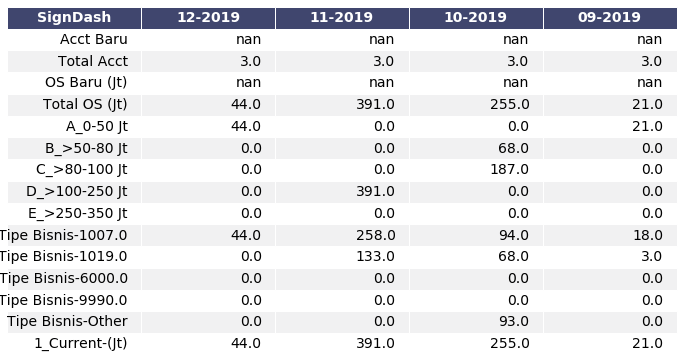

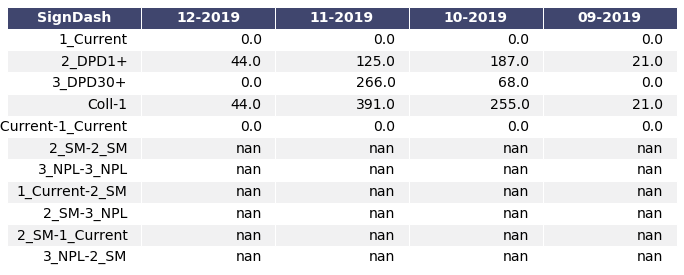

In [68]:
### Manajemen Dashboard ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six

ListCol = ['SignDash','12-2019','11-2019','10-2019','09-2019']

df_dashboard = df_union_all
df_dashboard_flowrate = pd.concat([df_dashboard,df_DashFlowrate])
df_dashboard_flowrate = df_dashboard_flowrate[ListCol]
df_trend1 = df_trend1[ListCol]
df_trend2 = df_trend2[ListCol]
df_trend3 = df_trend3[ListCol]
df_trend4 = df_trend4[ListCol]
df_trend5 = df_trend5[ListCol]
df_trend6 = df_trend6[ListCol]
df_trend7 = df_trend7[ListCol]
df_DashFlowrate = df_DashFlowrate[ListCol]
# print(df_dashboard_flowrate)

## Improverate dan flowrate ##
df_DashFlowrate.set_index("SignDash", inplace = True) 
df_DashFlowrate = df_DashFlowrate.loc[["1_Current-1_Current", "2_SM-2_SM","3_NPL-3_NPL","1_Current-2_SM",
                "2_SM-3_NPL","2_SM-1_Current","3_NPL-2_SM"]]
df_DashFlowrate.reset_index(inplace=True)
# print(df_DashFlowrate)

def render_mpl_table(data, col_width=1, row_height=0.4, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

df_trendPart1 = pd.concat([df_trend1,df_trend2,df_trend3,df_trend4,df_trend5])
df_trendPart2 = pd.concat([df_trend6,df_trend7,df_DashFlowrate])

render_mpl_table(df_trendPart1, header_columns=-1, col_width = 2.4)
DirResultPng = (r"C:\Data\Result\A3 Dashboard part1.png")
plt.savefig(DirResultPng)

render_mpl_table(df_trendPart2, header_columns=-1, col_width = 2.4)
DirResultPng = (r"C:\Data\Result\A3 Dashboard part2.png")
plt.savefig(DirResultPng)

# print('Membuat Manajemen dashboard per item - selesai')
# print(df_dashboard)

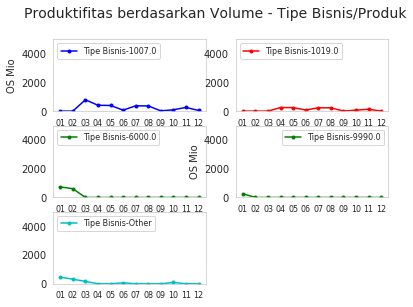

Menampilkan flowrate delinquent - selesai
Menampilkan Dpd - selesai


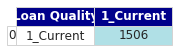

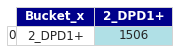

In [74]:
## Running Function ##
#Produktifitas_Debitur()
Produktifitas_TipeBisnis()
#Produktifitas_PijamanBI()
#Kualitas_Kolektibilitas()
#KualitasKredit_Improve_and_Flowrate()
#forecasting_NewAcct('M', 24)
Menampilkan_delq('03-2019')
Menampilkan_Dpd('03-2019')